In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_squared_error

In [2]:
i = pd.read_csv("final_IGF1R.csv", low_memory=False, index_col=0)
f = pd.read_csv("final_FGFR4.csv", low_memory=False, index_col=0)

In [17]:
# Concatenate the dataframes vertically
#i['target'] = 'IGF1R'
#f['target'] = 'FGFR4'
#df = pd.concat([i, f], ignore_index=True)
#df

In [4]:
Xi = i.drop(columns=['pIC50','smile'])
yi = i['pIC50']
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=42, shuffle=True)

Xf = f.drop(columns=['pIC50','smile'])
yf = f['pIC50']
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.2, random_state=42, shuffle=True)

In [5]:
def filter_features(df,test_df):
    print("Number of columns before any filter:", len(df.columns))
    
    variances = df.var()
    low_variance_threshold = 0.01  # Adjust as needed
    low_variance_columns = variances[variances < low_variance_threshold].index
    df = df.drop(columns=low_variance_columns)
    test_df = test_df.drop(columns=low_variance_columns)
    print("Number of columns after removing low variance columns:", len(df.columns))
    
    correlation_matrix = df.corr()
    high_correlation_threshold = 0.8  # Adjust as needed
    high_correlation_pairs = np.where(np.abs(correlation_matrix) > high_correlation_threshold)
    high_correlation_pairs_set = {(df.columns[i], df.columns[j])
                                  for i, j in zip(*high_correlation_pairs) if i != j}
    columns_to_remove = [col[0] for col in high_correlation_pairs_set]
    df = df.drop(columns=columns_to_remove)
    test_df = test_df.drop(columns=columns_to_remove)
    print("Number of columns after removing highly correlated columns:", len(df.columns))
    return df, test_df
    
print ("IGF1R")
Xi_train, Xi_test = filter_features(Xi_train, Xi_test)
print ("FGFR4")
Xf_train, Xf_test = filter_features(Xf_train, Xf_test)

IGF1R
Number of columns before any filter: 2308
Number of columns after removing low variance columns: 1462
Number of columns after removing highly correlated columns: 182
FGFR4
Number of columns before any filter: 2308
Number of columns after removing low variance columns: 1309
Number of columns after removing highly correlated columns: 152


FGFR4
(0.8968535601083691, 'PEOE_VSA2')
(0.8062632551209514, 'SlogP_VSA10')
(0.7225010980752868, 'MDEC-33')
(0.6714001903992104, 'PEOE_VSA9')
(0.6564571050493808, 'PEOE_VSA10')
(0.6489522186097876, 'EState_VSA8')
(0.6479546299519168, 'SlogP_VSA3')
(0.6360444544248391, 'EState_VSA2')
(0.6043462232352712, 'PEOE_VSA3')
(0.601931899739641, 'PEOE_VSA1')


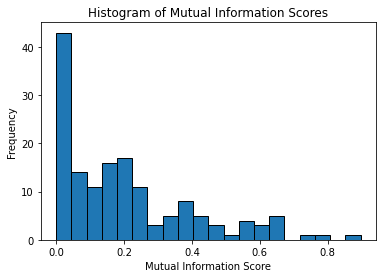

20 and Random Forest is done! 	best score is 0.5823094265318045
25 and Random Forest is done! 	best score is 0.5785183613939446
30 and Random Forest is done! 	best score is 0.5866815444387227
35 and Random Forest is done! 	best score is 0.5827928715001158
40 and Random Forest is done! 	best score is 0.5814083273183264
20 and Support Vector Machine is done! 	best score is 0.5334800842842082
25 and Support Vector Machine is done! 	best score is 0.49818055442609643
30 and Support Vector Machine is done! 	best score is 0.5113609136192643
35 and Support Vector Machine is done! 	best score is 0.5066702046700677
40 and Support Vector Machine is done! 	best score is 0.5139003780041956
20 and XGBoost is done! 	best score is 0.5762311120246201
25 and XGBoost is done! 	best score is 0.5834355330233375
30 and XGBoost is done! 	best score is 0.5805547322815322
35 and XGBoost is done! 	best score is 0.5778884428960949
40 and XGBoost is done! 	best score is 0.5746078330890765
20 and Gradient Boosting

,Method,Optimal Number of Features,Optimal Hyperparameters,Q2,MSEcv,R2train,MSEtrain,R2test,MSEtest
0,Random Forest,30,"{'max_depth': 20, 'n_estimators': 200}",0.586682,0.581408,0.938059,0.068100,0.603936,0.347830
1,Support Vector Machine,20,"{'C': 10, 'kernel': 'rbf'}",0.533480,0.513900,0.759235,0.264704,0.505601,0.434190
2,XGBoost,25,"{'learning_rate': 0.1, 'n_estimators': 100}",0.583436,0.574608,0.952010,0.052761,0.541364,0.402782
3,Gradient Boosting Regression Trees,30,"{'max_depth': 5, 'n_estimators': 200}",0.567754,0.565826,0.971001,0.031883,0.586099,0.363494


In [6]:
print ("FGFR4")

# Calculate mutual information between features and the target 'pIC50'
mutual_info = mutual_info_regression(Xf_train, yf_train)

# Sort features by mutual information in descending order
sorted_features = [f for _, f in sorted(zip(mutual_info, Xf_train.columns), reverse=True)]
for i in sorted(zip(mutual_info, Xf_train.columns), reverse=True)[:10]:
    print (i)

# Create a histogram plot of the mutual information scores
plt.hist(mutual_info, bins=20, edgecolor='black')
plt.xlabel('Mutual Information Score')
plt.ylabel('Frequency')
plt.title('Histogram of Mutual Information Scores')
plt.show()


# Define models and their hyperparameter grids
# Define the models and their respective hyperparameter grids
models = {
    'Random Forest': (RandomForestRegressor(),
                      {'n_estimators': [200], 'max_depth': [None, 10, 20]}),
    'Support Vector Machine': (SVR(),
                               {'C': [10], 'kernel': ['rbf']}),
    'XGBoost': (XGBRegressor(),
                {'learning_rate': [0.1], 'n_estimators': [100, 200, 300]}),
    'Gradient Boosting Regression Trees': (GradientBoostingRegressor(),
                                           {'n_estimators': [200], 'max_depth': [5]})
}


# Initialize results table
results = []

# Perform analysis for each model
for name, (model, params) in models.items():
    # Hyperparameter tuning and feature selection
    best_score = -np.inf
    best_features = None
    best_params = None

    for n_features in range(20, 41,5):
        # Select top N features
        Xf_train_selected = Xf_train[sorted_features[:n_features]]

        # 5-fold cross-validation and hyperparameter tuning
        grid_search = GridSearchCV(model, params, cv=8, scoring='r2', return_train_score=True)
        grid_search.fit(Xf_train_selected, yf_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_features = sorted_features[:n_features]
            best_params = grid_search.best_params_
            best_num_features = n_features
        print (n_features, "and", name, "is done!", "\tbest score is", grid_search.best_score_)

    # Train model with optimal hyperparameters and number of features
    optimal_model = model.set_params(**best_params)
    optimal_model.fit(Xf_train[best_features], yf_train)

    # Evaluate the model
    y_pred_train = optimal_model.predict(Xf_train[best_features])
    y_pred_test = optimal_model.predict(Xf_test[best_features])
    mse_cv = abs(grid_search.best_score_)
    r2_train = r2_score(yf_train, y_pred_train)
    mse_train = mean_squared_error(yf_train, y_pred_train)
    r2_test = r2_score(yf_test, y_pred_test)
    mse_test = mean_squared_error(yf_test, y_pred_test)

    # Store results
    results.append([name, best_num_features, best_params, best_score, mse_cv, r2_train, mse_train, r2_test, mse_test])


# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Method', 'Optimal Number of Features', 'Optimal Hyperparameters', 'Q2', 'MSEcv', 'R2train', 'MSEtrain', 'R2test', 'MSEtest'])
results_df

* All models show moderate to high accuracy on training data, with Gradient Boosting Regression Trees having the highest R2train and the lowest MSEtrain.
* For cross-validation and test performance, the Random Forest model shows slightly better generalizability (higher Q2 and R2test) than the others, though the differences are not very large.
* The Support Vector Machine has comparatively lower performance metrics across all categories.
* It's important to note that while R2train is high for all models, the Q2 values are moderate, indicating some overfitting to the training data.

IGF1R
(0.5148058952871977, 'SlogP_VSA8')
(0.42952802221384534, 'EState_VSA9')
(0.40426373426873585, 'SlogP_VSA10')
(0.4039947165546618, 'VSA_EState3')
(0.35533312263870176, 'SlogP_VSA1')
(0.3285201912573372, 'BCUTs-1h')
(0.3185035943433103, 'PEOE_VSA2')
(0.31456144717310197, 'SMR_VSA9')
(0.29919567575996275, 'MDEC-33')
(0.29631242890508824, 'PEOE_VSA9')


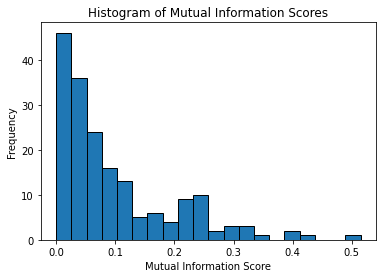

50 and Random Forest is done! 	best score is 0.7469712332824181
55 and Random Forest is done! 	best score is 0.7506056665294794
60 and Random Forest is done! 	best score is 0.7511312392885827
65 and Random Forest is done! 	best score is 0.7514744616326365
70 and Random Forest is done! 	best score is 0.7474554444134953
50 and Support Vector Machine is done! 	best score is 0.664188888993493
55 and Support Vector Machine is done! 	best score is 0.5662576680727022
60 and Support Vector Machine is done! 	best score is 0.5648714824072312
65 and Support Vector Machine is done! 	best score is 0.5239127933723398
70 and Support Vector Machine is done! 	best score is 0.5061009015126172
50 and XGBoost is done! 	best score is 0.7565712713236166
55 and XGBoost is done! 	best score is 0.7576002640882629
60 and XGBoost is done! 	best score is 0.7596600898634159
65 and XGBoost is done! 	best score is 0.7598499653910904
70 and XGBoost is done! 	best score is 0.7646619366501495
50 and Gradient Boosting R

,Method,Optimal Number of Features,Optimal Hyperparameters,Q2,MSEcv,R2train,MSEtrain,R2test,MSEtest
0,Random Forest,65,"{'max_depth': 20, 'n_estimators': 200}",0.751474,0.747455,0.965029,0.075875,0.783940,0.433716
1,Support Vector Machine,50,"{'C': 10, 'kernel': 'rbf'}",0.664189,0.506101,0.799038,0.436021,0.734267,0.533428
2,XGBoost,70,"{'learning_rate': 0.1, 'n_estimators': 200}",0.764662,0.764662,0.993474,0.014159,0.769199,0.463307
3,Gradient Boosting Regression Trees,70,"{'max_depth': 5, 'n_estimators': 200}",0.758155,0.758155,0.981755,0.039585,0.769238,0.463229


In [7]:
print ("IGF1R")

# Calculate mutual information between features and the target 'pIC50'
mutual_info = mutual_info_regression(Xi_train, yi_train)

# Sort features by mutual information in descending order
sorted_features = [f for _, f in sorted(zip(mutual_info, Xi_train.columns), reverse=True)]
for i in sorted(zip(mutual_info, Xi_train.columns), reverse=True)[:10]:
    print (i)

# Create a histogram plot of the mutual information scores
plt.hist(mutual_info, bins=20, edgecolor='black')
plt.xlabel('Mutual Information Score')
plt.ylabel('Frequency')
plt.title('Histogram of Mutual Information Scores')
plt.show()


# Define models and their hyperparameter grids
# Define the models and their respective hyperparameter grids
models = {
    'Random Forest': (RandomForestRegressor(),
                      {'n_estimators': [200], 'max_depth': [None, 10, 20]}),
    'Support Vector Machine': (SVR(),
                               {'C': [10], 'kernel': ['rbf']}),
    'XGBoost': (XGBRegressor(),
                {'learning_rate': [0.1], 'n_estimators': [100, 200, 300]}),
    'Gradient Boosting Regression Trees': (GradientBoostingRegressor(),
                                           {'n_estimators': [200], 'max_depth': [5]})
}



# Initialize results table
results = []

# Perform analysis for each model
for name, (model, params) in models.items():
    # Hyperparameter tuning and feature selection
    best_score = -np.inf
    best_features = None
    best_params = None

    for n_features in range(50, 71,5):
        # Select top N features
        Xi_train_selected = Xi_train[sorted_features[:n_features]]

        # 5-fold cross-validation and hyperparameter tuning
        grid_search = GridSearchCV(model, params, cv=8, scoring='r2', return_train_score=True)
        grid_search.fit(Xi_train_selected, yi_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_features = sorted_features[:n_features]
            best_params = grid_search.best_params_
            best_num_features = n_features
        print (n_features, "and", name, "is done!", "\tbest score is", grid_search.best_score_)

    # Train model with optimal hyperparameters and number of features
    optimal_model = model.set_params(**best_params)
    optimal_model.fit(Xi_train[best_features], yi_train)

    # Evaluate the model
    y_pred_train = optimal_model.predict(Xi_train[best_features])
    y_pred_test = optimal_model.predict(Xi_test[best_features])
    mse_cv = abs(grid_search.best_score_)
    r2_train = r2_score(yi_train, y_pred_train)
    mse_train = mean_squared_error(yi_train, y_pred_train)
    r2_test = r2_score(yi_test, y_pred_test)
    mse_test = mean_squared_error(yi_test, y_pred_test)

    # Store results
    results.append([name, best_num_features, best_params, best_score, mse_cv, r2_train, mse_train, r2_test, mse_test])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Method', 'Optimal Number of Features', 'Optimal Hyperparameters', 'Q2', 'MSEcv', 'R2train', 'MSEtrain', 'R2test', 'MSEtest'])
results_df